# Plot daytime and nighttime skin temperature on 16 July 2022
- This script is used to plot spatial variations of skin temperature on 16 July 2022 for Greater Manchester.
- Simulations: GM_SLUCM, GM_CLMU. 
- Reference data: MODIS, VIIRS.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import cartopy.crs as ccrs
import geopandas as gpd
from matplotlib.colors import ListedColormap
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import string
import matplotlib.patches as mpatches
home_path = '/gws/nopw/j04/duicv/yuansun/'

In [2]:
ds_wrf = xr.open_dataset(f'{home_path}0_WRFvsWRF-CTSM/archive/d04_wrf/wrfout_d01_2022-07-18_01:00:00.nc')
wrf_lat = ds_wrf['XLAT'][0,:,0].values
wrf_lon = ds_wrf['XLONG'][0,0,:].values
extent = [wrf_lon.min(), wrf_lon.max(), wrf_lat.min(), wrf_lat.max()]

In [3]:
wrf_lat

array([53.27471 , 53.28549 , 53.296276, 53.30706 , 53.317844, 53.328636,
       53.339424, 53.350204, 53.360992, 53.371773, 53.38256 , 53.39335 ,
       53.40413 , 53.414917, 53.425705, 53.43649 , 53.447273, 53.45806 ,
       53.468845, 53.47963 , 53.49041 , 53.501198, 53.511986, 53.52277 ,
       53.53355 , 53.544334, 53.555122, 53.565907, 53.576694, 53.587475,
       53.598255, 53.60904 , 53.61983 , 53.630615, 53.641396, 53.652176,
       53.662964, 53.67375 , 53.684532, 53.69532 , 53.7061  , 53.716885,
       53.72767 , 53.738453, 53.749233], dtype=float32)

In [3]:
model_list = ['wrf', 'wrf-ctsm', 'wrf-ctsm-noah']
time_list = ['day', 'night']
crs = "EPSG:4326"

In [4]:
shapefile_path = home_path + 'dataset/Office_for_National_Statistics/county_boundary/Counties_and_Unitary_Authorities_December_2023_Boundaries_UK_BSC_4915494739307740134/CTYUA_DEC_2023_UK_BSC.shp'
gdf = gpd.read_file(shapefile_path)
gdf_platecarree = gdf.to_crs(crs)
greater_manchester_counties = ['Bolton', 'Bury', 'Manchester', 'Oldham', 
                               'Rochdale','Salford', 'Stockport', 'Tameside', 
                               'Trafford', 'Wigan']
gdf_greater_manchester = gdf_platecarree[gdf_platecarree['CTYUA23NM'].isin(greater_manchester_counties)]

In [5]:
data_list = []
product_list = ['modis', 'viirs']
col_num = 5
row_num = 2
date = '16'
for i in range(col_num*row_num):
    idx_time = i // col_num
    time = time_list[idx_time]
    idx_model = i % col_num
    if idx_model < 3:
        model = model_list[idx_model]   
        if model =='wrf-ctsm-noah':
            model_filename = f'data_for_figure/{model}_{time}_07-16.nc'
        else:
            model_filename = f'{home_path}0_WRFvsWRF-CTSM/output_analysis/skin_temperature/data_for_figure/{model}_{time}_07-{date}.nc'    
        ds_date = xr.open_dataset(model_filename)
        data = ds_date['TSK'].values
    else:
        product_name = product_list[idx_model-3]
        #with rasterio.open(f'data_for_figure/modis_lst_gm_domain_{time}_16_19.tif') as src:
        with rasterio.open(f'{home_path}0_WRFvsWRF-CTSM/output_analysis/skin_temperature/data_for_figure/{product_name}_lst_{time}_{date}_07_2022_MCR.tif') as src:
            if product_name == 'modis':
                data = src.read(1)*0.02 - 273.15
                data = np.where(data > 0, data, np.nan)  
            else:
                data = src.read(1) -273.15  
    data_list.append(data) 
    #print(time, model, data_list[i].max(), data_list[i].min(), data_list[i].mean())     
    # Apply nan-safe statistics
    max_val = np.nanmax(data)
    min_val = np.nanmin(data)
    mean_val = np.nanmean(data)

    print(time, model, max_val, min_val, mean_val) 

day wrf 39.623 6.5746155 32.530006
day wrf-ctsm 36.81749 25.98735 31.85989
day wrf-ctsm-noah 38.91246 24.327377 32.208828
day wrf-ctsm-noah 38.07000000000005 19.430000000000007 30.10831492168181
day wrf-ctsm-noah 39.43000000000001 20.870000000000005 30.76210613052079
night wrf 13.108704 2.2252502 7.994064
night wrf-ctsm 10.835342 1.9649811 7.9287653
night wrf-ctsm-noah 16.689194 1.1863556 7.7755785
night wrf-ctsm-noah 13.910000000000025 5.770000000000039 8.658242624152495
night wrf-ctsm-noah 17.470000000000027 0.7700000000000387 8.67947435624604


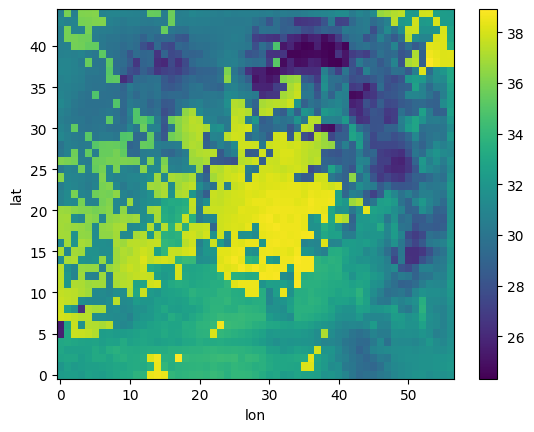

In [20]:
data_array = xr.DataArray(data_list[2], dims=('lat', 'lon'))
data_array.plot()

In [7]:
proj = ccrs.PlateCarree()
#cmap = 'rainbow'
base_cmap = plt.cm.get_cmap('rainbow')
colors_10 = base_cmap(np.linspace(0, 1, 10))
cmap_10 = ListedColormap(colors_10)
colors_9 = base_cmap(np.linspace(0, 1, 8))
cmap_9 = ListedColormap(colors_9)
labelcolor = '#6b6b6b'
linewidth = 0.5
length = 4
labelsize = 6
pad = 2
padding = 4
handletextpad = 0.5
boundarywidth = 0.5
#xticks = [-2.75, -2.50, -2.25, -2.00, -1.8]
xticks = [-2.75, -2.50, -2.25, -2.00]
yticks = [53.30, 53.50, 53.70]
title_list = ['GM_SLUCM at 13:30', 'GM_CLMU at 13:30', r'GM_CLMU$_\mathrm{NOAH}$ at 13:30', 'MODIS at daytime', 'VIIRS at daytime',
              'GM_SLUCM at 01:30', 'GM_CLMU at 01:30', r'GM_CLMU$_\mathrm{NOAH}$ at 01:30', 'MODIS at nighttime', 'VIIRS at nighttime']
marker = 'o'
markersize = 1
linestyle = '-'

/tmp/ipykernel_1005601/1360750620.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('rainbow')


In [8]:
ds_ctsm = xr.open_dataset(f'{home_path}0_WRFvsWRF-CTSM/input/WRF-CTSM/surfdata_1.2x1.2_SSP5-8.5_2022_78pfts_c250607.nc')
ctsm_lat = ds_ctsm['LATIXY'][:,0]
ctsm_lon = ds_ctsm['LONGXY'][0]
i1=23
i2=36
j1=12
j2=25
subset_lon = ctsm_lon[i1:i2] # lon
subset_lat = ctsm_lat[j1:j2] # lat
subset_lon_min, subset_lon_max = subset_lon.min(), subset_lon.max()
subset_lat_min, subset_lat_max = subset_lat.min(), subset_lat.max()
df_section = pd.read_csv(f'{home_path}0_WRFvsWRF-CTSM/output_analysis/skin_temperature_section/data_for_figure/section_info.csv')
df_section.head()

,lat,lon,index_lat,index_lon
0,53.274712,-2.582367,0,11
1,53.285488,-2.564331,1,12
2,53.296276,-2.546295,2,13
3,53.307060,-2.528259,3,14
4,53.317844,-2.510223,4,15


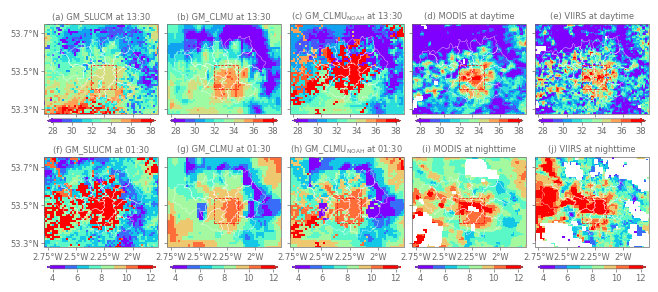

In [18]:
fig, axes = plt.subplots(row_num, col_num, figsize=(6.5, 2.8), subplot_kw={'projection':proj})
ax = axes.flatten()
vmin_list = [28, 4]
vmax_list = [38, 12]
for i in range(col_num * row_num):
    idx_time = i // col_num
    time = time_list[idx_time]
    idx_model = i % col_num
    ax[i].set_extent(extent)
    ax[i].set_xticks(xticks, crs = proj)
    ax[i].set_yticks(yticks, crs = proj)
    ax[i].xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False))
    ax[i].yaxis.set_major_formatter(LatitudeFormatter()) 
    ax[i].set_title(f'({string.ascii_lowercase[i]}) {title_list[i]}', fontsize=labelsize, color=labelcolor, pad=padding)
   # ax[i].plot(df_section['lon'], df_section['lat'], marker = marker, markersize = markersize, linewidth = linewidth, color='red', linestyle = linestyle, transform=proj, alpha = 0.25)
    if idx_model < 3:
        vmin = vmin_list[idx_time]
        vmax = vmax_list[idx_time]
        cs = ax[i].pcolormesh(wrf_lon, wrf_lat, data_list[i], vmin=vmin, vmax=vmax, cmap=[cmap_10, cmap_9][idx_time])
    else:
        vmin = vmin_list[idx_time]
        vmax = vmax_list[idx_time]
        cs = ax[i].imshow(data_list[i], cmap=[cmap_10, cmap_9][idx_time], vmin=vmin, vmax=vmax, extent=extent)
    if i % col_num == 0:
        labelleft=True 
    else:
        labelleft=False
    ax[i].tick_params(axis='y', labelleft=labelleft, labelsize=labelsize, length=length/2, pad =pad, width = boundarywidth,colors=labelcolor)
    if i // col_num == 0 :
        cbar_pad = 0.04
        labelbottom = False
        cbar_ticks = np.arange(vmin, vmax + 1, 2)
    else:
        cbar_pad = 0.15
        labelbottom = True   
        if i in [5]:
            cbar_ticks = np.arange(vmin, vmax + 1, 2) 
        else:
            cbar_ticks = np.arange(vmin, vmax + 1, 2)     
    ax[i].tick_params(axis='x', labelbottom=labelbottom, labelsize=labelsize, length=length/2, pad =pad, width = boundarywidth,colors=labelcolor)  
    gdf_greater_manchester.plot(ax=ax[i], edgecolor='white', linewidth = linewidth/2, facecolor='none', transform=proj)    
    rect = mpatches.Rectangle(
    (subset_lon_min, subset_lat_min),           # lower-left corner
    subset_lon_max - subset_lon_min,            # width
    subset_lat_max - subset_lat_min,            # height
    linewidth=linewidth,
    edgecolor='red',
    facecolor='none',
    linestyle='--',
    transform=ccrs.PlateCarree())
    ax[i].add_patch(rect) 

    cbar = plt.colorbar(cs, ax=ax[i], shrink=1, orientation='horizontal', location='bottom', pad=cbar_pad, extend='both', fraction=0.03, aspect=30)
    cbar.ax.tick_params(length=length/2,labelsize=labelsize, pad = 1, width=boundarywidth, colors=labelcolor)
    cbar.outline.set_linewidth(boundarywidth)
    cbar.outline.set_edgecolor(labelcolor)
    cbar.ax.yaxis.label.set_color(labelcolor)
    cbar.ax.set_xticks(cbar_ticks)
    #cbar.ax.set_position([0.1, 0.1, 0.4, 0.5])
    for spine in ax[i].spines.values():
        spine.set_linewidth(boundarywidth)
        spine.set_edgecolor(labelcolor)
      
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.04, top=0.99, wspace=0.075, hspace=0.225) 
fig.savefig('tskin_map_sensitivity.png', dpi=300)  
fig.savefig('tskin_map_sensitivity.pdf', dpi=600)       

# Description

In [88]:
model_list = ['wrf', 'wrf-ctsm']
time_list = ['day', 'night']
crs = "EPSG:4326"
product_list = ['modis', 'viirs']
col_num = 4
row_num = 2
for i in range(col_num*row_num):
    idx_time = i // col_num
    time = time_list[idx_time]
    idx_model = i % col_num
    target_lat = 53.47963
    target_lon = -2.23978
    if idx_model < 2:
        model = model_list[idx_model]    
        ds_date = xr.open_dataset(f'data_for_figure/{model}_{time}_mean.nc')
        ds = ds_date
        value = ds['TSK'][19, 30].values.item()
    else:
        product_name = product_list[idx_model-2]
        with rasterio.open(f'data_for_figure/{product_name}_lst_{time}_16_07_2022_MCR.tif') as src:
            row, col = src.index(target_lon, target_lat)
            value = src.read(1)[row, col]
            if product_name == 'modis':
                value = value * 0.02 - 273.15
            else:
                value = value - 273.15

    print(f'{time}, {model if idx_model<2 else product_name}, value at ({target_lat}, {target_lon}): {value:.1f} °C')

day, wrf, value at (53.47963, -2.23978): 34.7 °C
day, wrf-ctsm, value at (53.47963, -2.23978): 36.0 °C
day, modis, value at (53.47963, -2.23978): 35.4 °C
day, viirs, value at (53.47963, -2.23978): 34.2 °C
night, wrf, value at (53.47963, -2.23978): 12.4 °C
night, wrf-ctsm, value at (53.47963, -2.23978): 10.5 °C
night, modis, value at (53.47963, -2.23978): 11.9 °C
night, viirs, value at (53.47963, -2.23978): 14.5 °C
